# Variational Quantum Linear Solver (VQLS)

___

The **Variational Quantum Linear Solver (VQLS)** is a hybrid quantum–classical algorithm designed to solve linear systems of equations of the form:

$$
A \cdot x = b
$$

where:

- $A$ is the matrix of interest
- $b$ is the known vector  
- $x$ is the solution vector we want to obtain 

___





## VQLS in action

For purpose of this tutorial we would be working with $A$ matrix representing an Ising model. This is a simple toy model and might not have any practical use-case. Let us start with importing all the necessary modules. 

In [21]:
import numpy as np


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit_algorithms import optimizers as opt
from qiskit_aer import Aer
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit.library import UnitaryGate
import matplotlib.pyplot as plt

# Import the solver class from the repo
from vqls_prototype.solver.vqls import VQLS
from qiskit.visualization import circuit_drawer

import math
import random
from typing import List, Tuple, Dict
from collections import Counter
from scipy.optimize import minimize
from scipy.sparse import kron, identity, csr_matrix



from vqls_prototype.matrix_decomposition.matrix_decomposition import PauliDecomposition
from vqls_prototype.visualize import *


## Decomposing $A$ as a LCU

To run VQLS on a quantum computer, the matrix $A$ must be expressed as a linear combination of unitary (LCU) matrices:

$$
A = \sum_{l} c_l A_l
$$

where each $A_l$ is a unitary operator and $c_l$ are complex coefficients.

This decomposition enables efficient evaluation of matrix–vector products on quantum hardware.

In [44]:

# Problem parameters
N = 2 # Number of grid points in one dimension

#Ising matrix construction
ising_matrix = construct_ising_matrix(N, J=0.5, eta=1.0)# matrix is 2^N x 2^N

print("Ising Matrix:")
print(ising_matrix)

A = ising_matrix

Ising Matrix:
[[0.48994745 0.32663163 0.32663163 0.        ]
 [0.32663163 0.16331582 0.         0.32663163]
 [0.32663163 0.         0.16331582 0.32663163]
 [0.         0.32663163 0.32663163 0.48994745]]


In [45]:
# Create a PauliDecomposition object for matrix A
pauli_decomposer = PauliDecomposition(matrix=A)

coeffs, _, circuits = pauli_decomposer.decompose_matrix()
pauli_strings = pauli_decomposer.strings

print(pauli_decomposer._create_circuit)

100%|██████████| 16/16 [00:00<00:00, 4891.32it/s]

<function PauliDecomposition._create_circuit at 0x16c24aa70>


In [46]:
print("\n=== Pauli Decomposition Results ===")
for c, s in zip(coeffs, pauli_strings):
    print(f"{s}: {c}")


=== Pauli Decomposition Results ===
II: (0.3266316347104093+0j)
IX: (0.3266316347104093+0j)
XI: (0.3266316347104093+0j)
ZZ: (0.16331581735520467+0j)


In [47]:
def print_pauli_equation(coeffs, strings):
    terms = []
    for c, p in zip(coeffs, strings):
        # Remove tiny imaginary parts
        if abs(c.imag) < 1e-12:
            c = c.real
        terms.append(f"({c})*{p}")
    print("\nA = " + " + ".join(terms))

print_pauli_equation(coeffs, pauli_strings)


A = (0.3266316347104093)*II + (0.3266316347104093)*IX + (0.3266316347104093)*XI + (0.16331581735520467)*ZZ


This is how the matrix $A$ is decomposed as a LCU, in particular the LCU's here are tensor products of Pauli matrices.

___

## Variational Ansatz

VQLS prepares a **parameterized quantum state** (ansatz):

$$
|\psi(\theta)\rangle = V(\theta) |0\rangle
$$

where:

- $V(\theta)$ is a parameterized quantum circuit  
- $\theta$ is a vector of tunable parameters optimized classically  

We will use a hardware efficient ansatz.

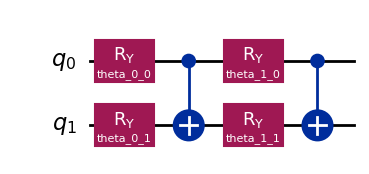

In [48]:
#N is no of qubits
V = hardware_efficient_ansatz_param(N, layers=2) # needs to change, doesn't match bravo structure

from qiskit.visualization import circuit_drawer
circuit_drawer(V, output='mpl', filename='variational_circuit.png')

___


## Encoding the Vector $\ket{b}$

The known vector $b$ is encoded using a unitary $U$:

$$
|b\rangle = U |0\rangle
$$

For this tutorial we assume that $b$ is an equal superposition state. For any other normalized $\ket{b}$ one can use qiskit's `StatePreparation` function. 

In [49]:
b_vector = np.ones(2**N) / np.sqrt(2**N) # Uniform superposition state

# the abobe b_vector can be prepared by applying Hadamard gates to all qubits starting from |0...0>
U = QuantumCircuit(N)
for i in range(N):
    U.h(i)

___

## Cost Function

The goal of VQLS is to produce an ansatz state $|\psi(\theta)\rangle$ whose image under $A$ is aligned with the target vector $|b\rangle$.  


This is achieved by minimizing the cost function:

$$
C(\theta) = 
\langle \psi(\theta) | 
A^\dagger (\mathbb{I} - |b\rangle\langle b|) A 
| \psi(\theta) \rangle
$$


We have seen from the tutorial that this cost can also be written as,

$$C_G(\theta)=1-\frac{\sum_{\ell,\ell'} c_\ell c_{\ell'}^* \gamma_{\ell\ell'}(\theta)}
        {\sum_{\ell,\ell'} c_\ell c_{\ell'}^* \beta_{\ell\ell'}(\theta)}$$

where 
$$ \beta_{\ell\ell'} = \bra{0} V^\dagger A_{\ell'}^\dagger A_\ell V \ket{0} $$
$$ \gamma_{\ell\ell'} = 
\bra{0} U^\dagger A_\ell V\ket{0}\,
\bra{0} V^\dagger A_{\ell'}^\dagger U\ket{0}
$$

The $\beta$ and $\gamma$ coefficients are evaluated through Hadamard tests, which are usually low depth quantum circuits.

#### Hadmard Test to calculate Cost Function

Let's start with a specific set of terms from the decomposition above to build our intuition on computing $\beta$ and $\gamma$ coefficients.

II IX


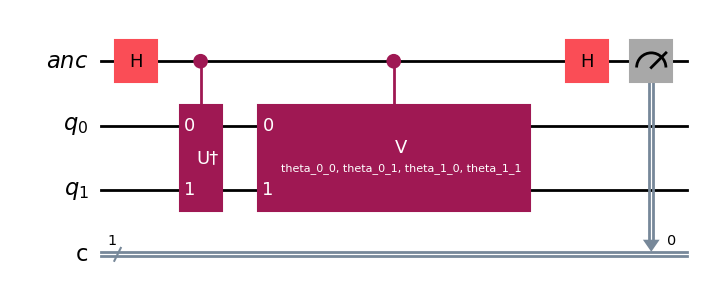

In [50]:
# Pauli strings
Al  = pauli_strings[0]  
Alp = pauli_strings[1]  

print(Al, Alp)

qc_beta  = hadamard_test_beta(V, Al, Alp)
qc_gamma_term = hadamard_test_gamma_Al(V, U, Al, Alp)

from qiskit.visualization import circuit_drawer

#Visualise Hadmard test circuit for beta
# circuit_drawer(qc_beta, output='mpl', filename='beta_circuit.png')
#Visualise Hadmard test circuit for gamma
circuit_drawer(qc_gamma_term, output='mpl', filename='gamma_circuit.png')

___

## Classical optimization

When the cost is minimized, the ansatz is proportional to the solution vector:

$$
x \propto |\psi(\theta^*)\rangle.
$$
____

In [51]:
# Set up quantum primitives
backend = Aer.get_backend("statevector_simulator")
estimator = Estimator()
sampler = Sampler()

# Choose classical optimizer
optimizer = opt.COBYLA(maxiter=500)

# instantiate VQLS solver
vqls = VQLS(
    estimator=estimator,
    ansatz=V,
    optimizer=optimizer,
    sampler=sampler,
    options={
        "matrix_decomposition": "symmetric",  # default
        "use_local_cost_function": False,     # global cost
        "use_overlap_test": False,            # standard Hadamard test
        "verbose": True
    }
)

# Solve Ax = b
result = vqls.solve(ising_matrix, b_vector)


/var/folders/vw/4v920b6d5vv0xtxg3kcw0f0h0000gn/T/ipykernel_45655/1475882360.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/var/folders/vw/4v920b6d5vv0xtxg3kcw0f0h0000gn/T/ipykernel_45655/1475882360.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## Post processing 

Explanation needed

Quantum solution (rescaled): [0.70653009 0.23514355 0.23584589 0.70650762]
Classical: [0.70651219 0.23550406 0.23550406 0.70651219]
Fidelity between quantum and classical solution: 0.9999997772093532


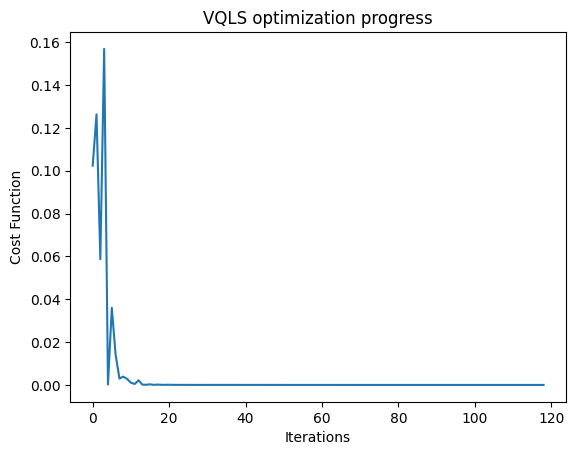

In [52]:
x_quantum = np.real(Statevector(result.state).data)

unnormalization_factor = 1 / np.sqrt(np.real(np.conj(x_quantum).T @ (ising_matrix.T.conj() @ (ising_matrix @ x_quantum))))
x_unnormalized = unnormalization_factor * x_quantum

# Now compare with the true classical solution
x_classical = np.linalg.solve(ising_matrix, b_vector)
print("Quantum solution (rescaled):", x_unnormalized)
print("Classical:", x_classical)
x_classical /= np.linalg.norm(x_classical)
print("Fidelity between quantum and classical solution:", np.abs(np.dot(np.conj(x_quantum), x_classical))**2)

# Optional plotting (if you logged cost)

if hasattr(vqls, "logger"):
    plt.plot(vqls.logger.values)
    plt.xlabel("Iterations")
    plt.ylabel("Cost Function")
    plt.title("VQLS optimization progress")
    plt.show()

___